# Feature_generation-pred11_to_12.ipynb

PBL01_需要予測・在庫最適化　サンプルコード(PBL01_sample_code)   
似ているkaggleのnotebook lag関数やgroupbyを踏まえて, データの整形やり直し

そこで作成したデータセットを使って, モデル作成

## TimeSeriesSplit

https://blog.amedama.jp/entry/time-series-cv

# インポート

In [1]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データの読み込み

In [18]:
data = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')
# test = pd.read_csv('./inputs/test.csv')
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)

In [19]:
len(data.columns)

470

In [20]:
data.columns[:int(len(data.columns)/5)]

Index(['月ブロック', '店舗ID', '商品ID', '売上個数', 'year_cat', 'month_cat', 'year',
       'month', '月ブロック_cat', 'holiday_cnt', 'month_cos', 'month_sin',
       '商品カテゴリID', '商品カテゴリ名', '商品カテゴリ_type1', '商品カテゴリ_type2', '商品カテゴリ_type3',
       'カテゴリ内_商品数', 'カテゴリtype1内_商品数', 'カテゴリtype2内_商品数', 'カテゴリtype3内_商品数',
       '商品カテゴリ名_contains_ゲーム', '商品カテゴリ名_contains_PC', '売上個数_lag_1',
       '売上個数_lag_2', '売上個数_lag_3', '売上個数_lag_4', '売上個数_lag_5', '売上個数_lag_6',
       '売上個数_lag_7', '売上個数_lag_8', '売上個数_lag_9', '売上個数_lag_10', '売上個数_lag_11',
       '売上個数_lag_12', '売上個数_date_mean_lag_1', '売上個数_date_mean_lag_2',
       '売上個数_date_mean_lag_3', '売上個数_date_mean_lag_4', '売上個数_date_mean_lag_5',
       '売上個数_date_mean_lag_6', '売上個数_date_mean_lag_7', '売上個数_date_mean_lag_8',
       '売上個数_date_mean_lag_9', '売上個数_date_mean_lag_10',
       '売上個数_date_mean_lag_11', '売上個数_date_mean_lag_12', '売上個数_date_std_lag_1',
       '売上個数_date_std_lag_2', '売上個数_date_std_lag_3', '売上個数_date_std_lag_4',
       '売上個数_date_std_lag_5', '売上個数_date_

In [21]:
data = data.drop('商品カテゴリID', axis=1)
data.head()

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0      0    0  1000001   6.0     2018        01  2018      1         0   
1      0    0  1000002   2.0     2018        01  2018      1         0   
2      0    0  1000003   0.0     2018        01  2018      1         0   
3      0    0  1000004   1.0     2018        01  2018      1         0   
4      0    0  1000005   8.0     2018        01  2018      1         0   

   holiday_cnt  month_cos  month_sin   商品カテゴリ名 商品カテゴリ_type1 商品カテゴリ_type2  \
0            2   0.866025        0.5  映画 - DVD          映画           DVD   
1            2   0.866025        0.5  映画 - DVD          映画           DVD   
2            2   0.866025        0.5  映画 - DVD          映画           DVD   
3            2   0.866025        0.5  映画 - DVD          映画           DVD   
4            2   0.866025        0.5  映画 - DVD          映画           DVD   

  商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
0         None       2733            4186            2733             NaN   
1         None       2733            4186            2733             NaN   
2         None       2733            4186            2733             NaN   
3         None       2733            4186            2733             NaN   
4         None       2733            4186            2733             NaN   

   商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  \
0                     0                    0         NaN         NaN   
1                     0                    0         NaN         NaN   
2                     0                    0         NaN         NaN   
3                     0                    0         NaN         NaN   
4                     0                    0         NaN         NaN   

   売上個数_lag_3  売上個数_lag_4  売上個数_lag_5  売上個数_lag_6  売上個数_lag_7  売上個数_lag_8  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   売上個数_lag_9  売上個数_lag_10  売上個数_lag_11  売上個数_lag_12  売上個数_date_mean_lag_1  \
0         NaN          NaN          NaN          NaN                   NaN   
1         NaN          NaN          NaN          NaN                   NaN   
2         NaN          NaN          NaN          NaN                   NaN   
3         NaN          NaN          NaN          NaN                   NaN   
4         NaN          NaN          NaN          NaN                   NaN   

   売上個数_date_mean_lag_2  売上個数_date_mean_lag_3  売上個数_date_mean_lag_4  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   売上個数_date_mean_lag_5  売上個数_date_mean_lag_6  売上個数_date_mean_lag_7  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   売上個数_date_mean_lag_8  売上個数_date_mean_lag_9  売上個数_date_mean_lag_10  \
0                   NaN                   NaN                    NaN   
1                   NaN                   NaN                    NaN   
2                   NaN                   NaN                    NaN   
3                   NaN                   NaN                    NaN   
4                   NaN                   NaN              

## 型

In [22]:
cat_col = [col for col in data.select_dtypes(include=object)]
num_col = [col for col in data.select_dtypes(exclude=object)]

# 関数

In [23]:
#説明変数を対数変換
def logarithmic_transformation(df):
    num_col = [col for col in df.select_dtypes(exclude=object)]
    
    print(num_col)
    #各説明変数の歪度を計算
    skewed_feats = df[num_col].apply(lambda x: x.skew()).sort_values(ascending = False)
    
    #歪度の絶対値が0.5より大きい変数だけに絞る
    skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5]
    
    #欠損値のないものに絞る
    num_col_feat_list = []
    for i in skewed_feats_over.index:
        flag = df[i].isnull().any()
        if not flag:
            num_col_feat_list.append(i)

    print(num_col_feat_list)
    
    #グラフ化
    skewed_feats_over_plot = skewed_feats_over[num_col_feat_list]
    
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_over_plot.index, y=skewed_feats_over_plot)
    
    #Yeo-Johnson変換
    pt = PowerTransformer()
    pt.fit(df[num_col_feat_list])

    #変換後のデータで各列を置換
    tmp = pd.DataFrame()
    tmp[num_col_feat_list] = pt.transform(df[num_col_feat_list])
    tmp = tmp.add_prefix('Log_')
    df[tmp.columns] = tmp
    
    #各説明変数の歪度を計算
    skewed_feats_fixed = df[tmp.columns].apply(lambda x:x.skew()).sort_values(ascending = False)

    #グラフ化
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

    return df, num_col_feat_list, pt

"""=================================================="""

#カテゴリカル変数化
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

    #ターゲットカラム以外にカテゴリ変数があれば, ダミー変数にする
    #df2 = pd.get_dummies(df2, drop_first=True)
    df2 = pd.get_dummies(df2)

    for column in tqdm(target_columns):
        df2[column] = df2[column].astype('category')

    return df2

"""=================================================="""

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

# データセットの整理

In [24]:
X_data = data[(data['月ブロック'] >= 12)].drop(['売上個数'], axis=1)
y_data = data[(data['月ブロック'] >= 12)]['売上個数']

In [25]:
X_data

月ブロック 店舗ID     商品ID year_cat month_cat  year  month 月ブロック_cat  \
331704      12    0  1000001     2019        01  2019      1        12   
331705      12    0  1000002     2019        01  2019      1        12   
331706      12    0  1000003     2019        01  2019      1        12   
331707      12    0  1000004     2019        01  2019      1        12   
331708      12    0  1000005     2019        01  2019      1        12   
...        ...  ...      ...      ...       ...   ...    ...       ...   
1655023     23   13  3500001     2019        12  2019     12        23   
1655024     23   14  3500001     2019        12  2019     12        23   
1655025     23   15  3500001     2019        12  2019     12        23   
1655026     23   16  3500001     2019        12  2019     12        23   
1655027     23   17  3500001     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin            商品カテゴリ名 商品カテゴリ_type1  \
331704             2   0.866025  5.000000e-01           映画 - DVD          映画    
331705             2   0.866025  5.000000e-01           映画 - DVD          映画    
331706             2   0.866025  5.000000e-01           映画 - DVD          映画    
331707             2   0.866025  5.000000e-01           映画 - DVD          映画    
331708             2   0.866025  5.000000e-01           映画 - DVD          映画    
...              ...        ...           ...                ...          ...   
1655023            0   1.000000 -2.449294e-16  本 - オーディオブック_タイプB           本    
1655024            0   1.000000 -2.449294e-16  本 - オーディオブック_タイプB           本    
1655025            0   1.000000 -2.449294e-16  本 - オーディオブック_タイプB           本    
1655026            0   1.000000 -2.449294e-16  本 - オーディオブック_タイプB           本    
1655027            0   1.000000 -2.449294e-16  本 - オーディオブック_タイプB           本    

        商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  \
331704           DVD         None       2733            4186            2733   
331705           DVD         None       2733            4186            2733   
331706           DVD         None       2733            4186            2733   
331707           DVD         None       2733            4186            2733   
331708           DVD         None       2733            4186            2733   
...              ...          ...        ...             ...             ...   
1655023     オーディオブック         タイプB         76             445             357   
1655024     オーディオブック         タイプB         76             445             357   
1655025     オーディオブック         タイプB         76             445             357   
1655026     オーディオブック         タイプB         76             445             357   
1655027     オーディオブック         タイプB         76             445             357   

         カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  \
331704              NaN                     0                    0   
331705              NaN                     0                    0   
331706              NaN                     0                    0   
331707              NaN                     0                    0   
331708              NaN                     0                    0   
...                 ...                   ...                  ...   
1655023           165.0                     0                    0   
1655024           165.0                     0                    0   
1655025           165.0                     0                    0   
1655026           165.0                     0                    0   
1655027           165.0                     0                    0   

         売上個数_lag_1  売上個数_lag_2  売上個数_lag_3  売上個数_lag_4  売上個数_lag_5  \
331704          0.0         2.0         0.0         1.0         2.0   
331705          0.0         0.0         1.0         2.0         0.0   
331706          2.0         0.0         0.0         1.0         0.0   
331707          0.0         0.0         0.0         0.0      

In [26]:
y_data

331704     2.0
331705     0.0
331706     0.0
331707     0.0
331708     1.0
          ... 
1655023    NaN
1655024    NaN
1655025    NaN
1655026    NaN
1655027    NaN
Name: 売上個数, Length: 665946, dtype: float16

## カテゴリ変数化

In [27]:
cat_col

['店舗ID',
 '商品ID',
 'year_cat',
 'month_cat',
 '月ブロック_cat',
 '商品カテゴリ名',
 '商品カテゴリ_type1',
 '商品カテゴリ_type2',
 '商品カテゴリ_type3',
 '店舗別_売上個数_クラスタ_cat',
 '商品別_売上個数_クラスタ_cat']

In [28]:
for cat in cat_col:
    print(cat)
    print(X_data[cat].nunique(dropna=False))
    print('*' * 100)

店舗ID
18
****************************************************************************************************
商品ID
6629
****************************************************************************************************
year_cat
1
****************************************************************************************************
month_cat
12
****************************************************************************************************
月ブロック_cat
12
****************************************************************************************************
商品カテゴリ名
26
****************************************************************************************************
商品カテゴリ_type1
8
****************************************************************************************************
商品カテゴリ_type2
22
****************************************************************************************************
商品カテゴリ_type3
3
********************************************************************************

In [29]:
#labelencodingするカラム → コメントアウト one-hot変換
labelencoding_columns = [
    #'店舗ID',
 '商品ID',
 #'year_cat',
 #'month_cat',
 #'月ブロック_cat',
 '商品カテゴリ名',
 #'商品カテゴリ_type1',
 #'商品カテゴリ_type2',
 #'商品カテゴリ_type3',
#'店舗別_売上個数_クラスタ_cat',
 #'商品別_売上個数_クラスタ_cat'
]

X_data_dummy = process_categorical(X_data, labelencoding_columns)

  0%|          | 0/2 [00:00<?, ?it/s]

# データセットを入力値、目標値に分割

In [30]:
X_data_dummy[X_data_dummy.月ブロック == 22]

月ブロック  商品ID  year  month  holiday_cnt  month_cos  month_sin 商品カテゴリ名  \
1648908     22     0  2019     11            3   0.866025       -0.5      16   
1648909     22     0  2019     11            3   0.866025       -0.5      16   
1648910     22     0  2019     11            3   0.866025       -0.5      16   
1648911     22     0  2019     11            3   0.866025       -0.5      16   
1648912     22     0  2019     11            3   0.866025       -0.5      16   
...        ...   ...   ...    ...          ...        ...        ...     ...   
1651963     22  6585  2019     11            3   0.866025       -0.5      21   
1651964     22  6585  2019     11            3   0.866025       -0.5      21   
1651965     22  6585  2019     11            3   0.866025       -0.5      21   
1651966     22  6585  2019     11            3   0.866025       -0.5      21   
1651967     22  6585  2019     11            3   0.866025       -0.5      21   

         カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
1648908       2733            4186            2733             NaN   
1648909       2733            4186            2733             NaN   
1648910       2733            4186            2733             NaN   
1648911       2733            4186            2733             NaN   
1648912       2733            4186            2733             NaN   
...            ...             ...             ...             ...   
1651963         76             445             357           165.0   
1651964         76             445             357           165.0   
1651965         76             445             357           165.0   
1651966         76             445             357           165.0   
1651967         76             445             357           165.0   

         商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  \
1648908                     0                    0         0.0         1.0   
1648909                     0                    0         0.0         0.0   
1648910                     0                    0         2.0         0.0   
1648911                     0                    0         2.0         3.0   
1648912                     0                    0        12.0         8.0   
...                       ...                  ...         ...         ...   
1651963                     0                    0         2.0         3.0   
1651964                     0                    0         0.0         0.0   
1651965                     0                    0         0.0         0.0   
1651966                     0                    0         0.0         0.0   
1651967                     0                    0         0.0         0.0   

         売上個数_lag_3  売上個数_lag_4  売上個数_lag_5  売上個数_lag_6  売上個数_lag_7  \
1648908         0.0         2.0         0.0         0.0         0.0   
1648909         0.0         0.0         0.0         0.0         0.0   
1648910         3.0         0.0         2.0         0.0         1.0   
1648911         6.0         5.0         4.0         5.0         2.0   
1648912        14.0         9.0         6.0         5.0         3.0   
...             ...         ...         ...         ...         ...   
1651963         1.0         1.0         1.0         2.0         0.0   
1651964         0.0         0.0         0.0         0.0         0.0   
1651965         0.0         0.0         0.0         1.0         0.0   
1651966         0.0         0.0         0.0         0.0         0.0   
1651967         0.0         0.0         0.0         0.0         0.0   

         売上個数_lag_8  売上個数_lag_9  売上個数_lag_10  売上個数_lag_11  売上個数_lag_12  \
1648908         0.0         1.0          2.0          0.0          2.0   
1648909         0.0         0.0          0.0          0.0          0.0   
1648910         1.0         2.0          0.0          0.0          1.0   
1648911         3.0         2.0          5.0          9.0          7.0   
1648912         6.0         8.0          4.0   

In [31]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_trainval = X_data_dummy[(X_data_dummy.月ブロック >= 12) & (X_data_dummy.月ブロック <= 21)]
y_trainval = y_data[(X_data_dummy.月ブロック>= 12) & (X_data_dummy.月ブロック <= 21)] #1 ~ 10月

X_test_month11 = X_data_dummy[X_data_dummy.月ブロック == 22] #11月
X_test_month12 = X_data_dummy[X_data_dummy.月ブロック == 23] #12月

In [32]:
X_trainval

月ブロック  商品ID  year  month  holiday_cnt  month_cos  month_sin 商品カテゴリ名  \
331704      12     0  2019      1            2   0.866025   0.500000      16   
331705      12     1  2019      1            2   0.866025   0.500000      16   
331706      12     2  2019      1            2   0.866025   0.500000      16   
331707      12     3  2019      1            2   0.866025   0.500000      16   
331708      12     4  2019      1            2   0.866025   0.500000      16   
...        ...   ...   ...    ...          ...        ...        ...     ...   
1076611     21  6618  2019     10            2   0.500000  -0.866025      21   
1076612     21  6625  2019     10            2   0.500000  -0.866025      21   
1076613     21  6626  2019     10            2   0.500000  -0.866025      21   
1076614     21  6627  2019     10            2   0.500000  -0.866025      21   
1076615     21  6628  2019     10            2   0.500000  -0.866025      21   

         カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
331704        2733            4186            2733             NaN   
331705        2733            4186            2733             NaN   
331706        2733            4186            2733             NaN   
331707        2733            4186            2733             NaN   
331708        2733            4186            2733             NaN   
...            ...             ...             ...             ...   
1076611         76             445             357           165.0   
1076612         76             445             357           165.0   
1076613         76             445             357           165.0   
1076614         76             445             357           165.0   
1076615         76             445             357           165.0   

         商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  \
331704                      0                    0         0.0         2.0   
331705                      0                    0         0.0         0.0   
331706                      0                    0         2.0         0.0   
331707                      0                    0         0.0         0.0   
331708                      0                    0         1.0         1.0   
...                       ...                  ...         ...         ...   
1076611                     0                    0         0.0         0.0   
1076612                     0                    0         0.0         NaN   
1076613                     0                    0         NaN         NaN   
1076614                     0                    0         NaN         NaN   
1076615                     0                    0         NaN         NaN   

         売上個数_lag_3  売上個数_lag_4  売上個数_lag_5  売上個数_lag_6  売上個数_lag_7  \
331704          0.0         1.0         2.0         3.0         4.0   
331705          1.0         2.0         0.0         1.0         0.0   
331706          0.0         1.0         0.0         1.0         0.0   
331707          0.0         0.0         0.0         0.0         0.0   
331708          2.0         0.0         2.0         3.0         2.0   
...             ...         ...         ...         ...         ...   
1076611         1.0         0.0         0.0         0.0         NaN   
1076612         NaN         NaN         NaN         NaN         NaN   
1076613         NaN         NaN         NaN         NaN         NaN   
1076614         NaN         NaN         NaN         NaN         NaN   
1076615         NaN         NaN         NaN         NaN         NaN   

         売上個数_lag_8  売上個数_lag_9  売上個数_lag_10  売上個数_lag_11  売上個数_lag_12  \
331704          0.0         2.0          1.0          3.0          6.0   
331705          2.0         0.0          1.0          0.0          2.0   
331706          0.0         1.0          0.0          1.0          0.0   
331707          2.0         0.0          2.0          1.0          1.0   
331708          2.0         2.0          2.0   

In [33]:
y_trainval

331704     2.0
331705     0.0
331706     0.0
331707     0.0
331708     1.0
          ... 
1076611    0.0
1076612    0.0
1076613    0.0
1076614    0.0
1076615    0.0
Name: 売上個数, Length: 659826, dtype: float16

# 目的変数の前処理

y_train
歪度: nan
尖度: nan
np.exp(train_y_log)
歪度: nan
尖度: nan


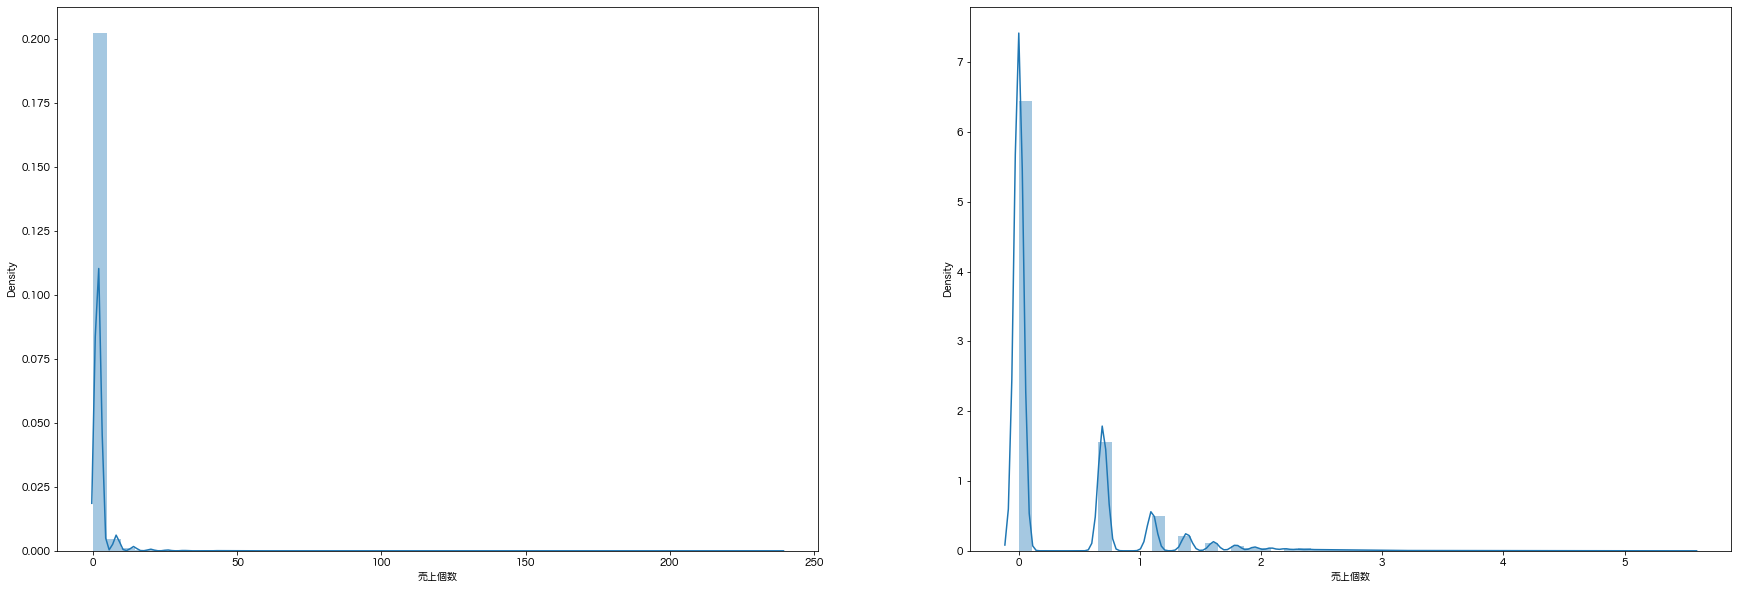

In [34]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 10])

sns.distplot(y_data[y_data.notnull()], ax=ax1)
#歪度と尖度を計算
print('y_train')
print("歪度: %f" % y_data.skew())
print("尖度: %f" % y_data.kurt())

print('=============')

sns.distplot(np.log1p(y_data[y_data.notnull()]), ax=ax2)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % np.log1p(y_data[y_data.notnull()]).skew())
print("尖度: %f" % np.log1p(y_data[y_data.notnull()]).kurt())

# パラメータチューニング¶

In [37]:
X_trainval

月ブロック  商品ID  year  month  holiday_cnt  month_cos  month_sin 商品カテゴリ名  \
331704      12     0  2019      1            2   0.866025   0.500000      16   
331705      12     1  2019      1            2   0.866025   0.500000      16   
331706      12     2  2019      1            2   0.866025   0.500000      16   
331707      12     3  2019      1            2   0.866025   0.500000      16   
331708      12     4  2019      1            2   0.866025   0.500000      16   
...        ...   ...   ...    ...          ...        ...        ...     ...   
1076611     21  6618  2019     10            2   0.500000  -0.866025      21   
1076612     21  6625  2019     10            2   0.500000  -0.866025      21   
1076613     21  6626  2019     10            2   0.500000  -0.866025      21   
1076614     21  6627  2019     10            2   0.500000  -0.866025      21   
1076615     21  6628  2019     10            2   0.500000  -0.866025      21   

         カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
331704        2733            4186            2733             NaN   
331705        2733            4186            2733             NaN   
331706        2733            4186            2733             NaN   
331707        2733            4186            2733             NaN   
331708        2733            4186            2733             NaN   
...            ...             ...             ...             ...   
1076611         76             445             357           165.0   
1076612         76             445             357           165.0   
1076613         76             445             357           165.0   
1076614         76             445             357           165.0   
1076615         76             445             357           165.0   

         商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  売上個数_lag_1  売上個数_lag_2  \
331704                      0                    0         0.0         2.0   
331705                      0                    0         0.0         0.0   
331706                      0                    0         2.0         0.0   
331707                      0                    0         0.0         0.0   
331708                      0                    0         1.0         1.0   
...                       ...                  ...         ...         ...   
1076611                     0                    0         0.0         0.0   
1076612                     0                    0         0.0         NaN   
1076613                     0                    0         NaN         NaN   
1076614                     0                    0         NaN         NaN   
1076615                     0                    0         NaN         NaN   

         売上個数_lag_3  売上個数_lag_4  売上個数_lag_5  売上個数_lag_6  売上個数_lag_7  \
331704          0.0         1.0         2.0         3.0         4.0   
331705          1.0         2.0         0.0         1.0         0.0   
331706          0.0         1.0         0.0         1.0         0.0   
331707          0.0         0.0         0.0         0.0         0.0   
331708          2.0         0.0         2.0         3.0         2.0   
...             ...         ...         ...         ...         ...   
1076611         1.0         0.0         0.0         0.0         NaN   
1076612         NaN         NaN         NaN         NaN         NaN   
1076613         NaN         NaN         NaN         NaN         NaN   
1076614         NaN         NaN         NaN         NaN         NaN   
1076615         NaN         NaN         NaN         NaN         NaN   

         売上個数_lag_8  売上個数_lag_9  売上個数_lag_10  売上個数_lag_11  売上個数_lag_12  \
331704          0.0         2.0          1.0          3.0          6.0   
331705          2.0         0.0          1.0          0.0          2.0   
331706          0.0         1.0          0.0          1.0          0.0   
331707          2.0         0.0          2.0          1.0          1.0   
331708          2.0         2.0          2.0   

In [39]:
y_trainval

331704     2.0
331705     0.0
331706     0.0
331707     0.0
331708     1.0
          ... 
1076611    0.0
1076612    0.0
1076613    0.0
1076614    0.0
1076615    0.0
Name: 売上個数, Length: 659826, dtype: float16

In [40]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_train = X_trainval[(X_trainval.月ブロック >= 12) & (X_trainval.月ブロック < 21)]
y_train = y_trainval[(X_trainval.月ブロック>= 12) & (X_trainval.月ブロック< 21)]

X_valid = X_trainval[X_trainval.月ブロック == 21] #10月
y_valid = y_trainval[X_trainval.月ブロック == 21]

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(601974, 549)
(601974,)
(57852, 549)
(57852,)


In [42]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

dtrain_tuning = op_lgb.Dataset(X_train.values, label=y_train.values)
dval_tuning = op_lgb.Dataset(X_valid.values, label=y_valid.values)

In [43]:
ts = time.time()

best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(回帰モデル用)
tuning_params = {'objective': 'regression',
          'metric': 'rmse',
          'num_boost_round': 5000, # 最大試行数
          'random_seed':100,
         'learning_rate': 0.01, # 学習率
         }

booster = op_lgb.train(tuning_params, 
                       dtrain_tuning, 
                       valid_sets=[dtrain_tuning, dval_tuning],
                       verbose_eval=1000,
                       early_stopping_rounds=5,)

time.time() - ts

[I 2021-09-28 02:47:37,444] A new study created in memory with name: no-name-113b024b-35a7-4317-9452-36932d40b8ab
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.75268	valid_1's rmse: 2.89388
[200]	valid_0's rmse: 1.55906	valid_1's rmse: 2.73862
[300]	valid_0's rmse: 1.47081	valid_1's rmse: 2.66769
[400]	valid_0's rmse: 1.4233	valid_1's rmse: 2.6293
[500]	valid_0's rmse: 1.38966	valid_1's rmse: 2.60084
[600]	valid_0's rmse: 1.36595	valid_1's rmse: 2.5757
[700]	valid_0's rmse: 1.34746	valid_1's rmse: 2.55605


feature_fraction, val_score: 2.556050:  14%|8     | 1/7 [01:15<07:32, 75.39s/it]

Early stopping, best iteration is:
[701]	valid_0's rmse: 1.34733	valid_1's rmse: 2.55605
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.73061	valid_1's rmse: 2.87367
[200]	valid_0's rmse: 1.53593	valid_1's rmse: 2.72729
[300]	valid_0's rmse: 1.4537	valid_1's rmse: 2.6561
[400]	valid_0's rmse: 1.40622	valid_1's rmse: 2.61135
[500]	valid_0's rmse: 1.37643	valid_1's rmse: 2.58722
[600]	valid_0's rmse: 1.35388	valid_1's rmse: 2.56395
[700]	valid_0's rmse: 1.33734	valid_1's rmse: 2.54614
[800]	valid_0's rmse: 1.32332	valid_1's rmse: 2.53606


feature_fraction, val_score: 2.534469:  29%|#7    | 2/7 [02:14<05:27, 65.57s/it]

Early stopping, best iteration is:
[812]	valid_0's rmse: 1.32178	valid_1's rmse: 2.53447
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.72355	valid_1's rmse: 2.86466
[200]	valid_0's rmse: 1.52995	valid_1's rmse: 2.7259
[300]	valid_0's rmse: 1.44975	valid_1's rmse: 2.66172
[400]	valid_0's rmse: 1.40416	valid_1's rmse: 2.61488
[500]	valid_0's rmse: 1.37468	valid_1's rmse: 2.58526
[600]	valid_0's rmse: 1.35246	valid_1's rmse: 2.56432
[700]	valid_0's rmse: 1.33568	valid_1's rmse: 2.55003


feature_fraction, val_score: 2.534469:  43%|##5   | 3/7 [03:05<03:56, 59.01s/it]

Early stopping, best iteration is:
[729]	valid_0's rmse: 1.33156	valid_1's rmse: 2.54627
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.72087	valid_1's rmse: 2.84827
[200]	valid_0's rmse: 1.52717	valid_1's rmse: 2.69782
[300]	valid_0's rmse: 1.44183	valid_1's rmse: 2.60113
[400]	valid_0's rmse: 1.3975	valid_1's rmse: 2.56408
[500]	valid_0's rmse: 1.36932	valid_1's rmse: 2.53463
[600]	valid_0's rmse: 1.34936	valid_1's rmse: 2.51694
[700]	valid_0's rmse: 1.33303	valid_1's rmse: 2.50694


feature_fraction, val_score: 2.506933:  57%|###4  | 4/7 [03:54<02:44, 55.00s/it]

Early stopping, best iteration is:
[701]	valid_0's rmse: 1.3329	valid_1's rmse: 2.50693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.72069	valid_1's rmse: 2.84477
[200]	valid_0's rmse: 1.52698	valid_1's rmse: 2.68825
[300]	valid_0's rmse: 1.4423	valid_1's rmse: 2.59968
[400]	valid_0's rmse: 1.39898	valid_1's rmse: 2.56423
[500]	valid_0's rmse: 1.37029	valid_1's rmse: 2.53947
[600]	valid_0's rmse: 1.34905	valid_1's rmse: 2.52225
[700]	valid_0's rmse: 1.33353	valid_1's rmse: 2.51256


feature_fraction, val_score: 2.506933:  71%|####2 | 5/7 [04:48<01:49, 54.61s/it]

Early stopping, best iteration is:
[733]	valid_0's rmse: 1.32879	valid_1's rmse: 2.51004
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.72071	valid_1's rmse: 2.85992
[200]	valid_0's rmse: 1.52781	valid_1's rmse: 2.7101
[300]	valid_0's rmse: 1.44516	valid_1's rmse: 2.63464
[400]	valid_0's rmse: 1.40045	valid_1's rmse: 2.59217
[500]	valid_0's rmse: 1.37172	valid_1's rmse: 2.56491
[600]	valid_0's rmse: 1.35084	valid_1's rmse: 2.54552
[700]	valid_0's rmse: 1.33514	valid_1's rmse: 2.53393
[800]	valid_0's rmse: 1.32182	valid_1's rmse: 2.52625
[900]	va

feature_fraction, val_score: 2.506933:  86%|#####1| 6/7 [05:46<00:55, 55.87s/it]

Early stopping, best iteration is:
[912]	valid_0's rmse: 1.30719	valid_1's rmse: 2.52009
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.73672	valid_1's rmse: 2.87041
[200]	valid_0's rmse: 1.54291	valid_1's rmse: 2.73142
[300]	valid_0's rmse: 1.45845	valid_1's rmse: 2.65439
[400]	valid_0's rmse: 1.4133	valid_1's rmse: 2.61695
[500]	valid_0's rmse: 1.38083	valid_1's rmse: 2.58582
[600]	valid_0's rmse: 1.35813	valid_1's rmse: 2.56577
[700]	valid_0's rmse: 1.34033	valid_1's rmse: 2.54918
[800]	valid_0's rmse: 1.32599	valid_1's rmse: 2.53719


feature_fraction, val_score: 2.506933: 100%|######| 7/7 [07:24<00:00, 63.46s/it]


Early stopping, best iteration is:
[803]	valid_0's rmse: 1.32551	valid_1's rmse: 2.53699


num_leaves, val_score: 2.506933:   0%|                   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.91493	valid_1's rmse: 2.99182
[200]	valid_0's rmse: 1.77749	valid_1's rmse: 2.85701
[300]	valid_0's rmse: 1.7158	valid_1's rmse: 2.79435
[400]	valid_0's rmse: 1.67104	valid_1's rmse: 2.73253
[500]	valid_0's rmse: 1.63896	valid_1's rmse: 2.70111
[600]	valid_0's rmse: 1.61225	valid_1's rmse: 2.67846
[700]	valid_0's rmse: 1.59105	valid_1's rmse: 2.66251
[800]	valid_0's rmse: 1.57469	valid_1's rmse: 2.64955


num_leaves, val_score: 2.506933:   5%|5          | 1/20 [00:42<13:18, 42.04s/it]

Early stopping, best iteration is:
[890]	valid_0's rmse: 1.56268	valid_1's rmse: 2.63653
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.79858	valid_1's rmse: 2.89139
[200]	valid_0's rmse: 1.62731	valid_1's rmse: 2.75173
[300]	valid_0's rmse: 1.54917	valid_1's rmse: 2.67806
[400]	valid_0's rmse: 1.50578	valid_1's rmse: 2.63144
[500]	valid_0's rmse: 1.47618	valid_1's rmse: 2.61388
[600]	valid_0's rmse: 1.45356	valid_1's rmse: 2.59451
[700]	valid_0's rmse: 1.43728	valid_1's rmse: 2.58107


num_leaves, val_score: 2.506933:  10%|#1         | 2/20 [01:27<13:07, 43.77s/it]

Early stopping, best iteration is:
[769]	valid_0's rmse: 1.42682	valid_1's rmse: 2.5703
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.5968	valid_1's rmse: 2.76568
[200]	valid_0's rmse: 1.37357	valid_1's rmse: 2.60904
[300]	valid_0's rmse: 1.28575	valid_1's rmse: 2.55004
[400]	valid_0's rmse: 1.23948	valid_1's rmse: 2.52105
[500]	valid_0's rmse: 1.21043	valid_1's rmse: 2.50878


num_leaves, val_score: 2.503727:  15%|#6         | 3/20 [02:35<15:37, 55.17s/it]

Early stopping, best iteration is:
[569]	valid_0's rmse: 1.1949	valid_1's rmse: 2.50373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.75246	valid_1's rmse: 2.87465
[200]	valid_0's rmse: 1.56725	valid_1's rmse: 2.72544
[300]	valid_0's rmse: 1.48523	valid_1's rmse: 2.62822
[400]	valid_0's rmse: 1.44175	valid_1's rmse: 2.59246
[500]	valid_0's rmse: 1.41195	valid_1's rmse: 2.56756
[600]	valid_0's rmse: 1.39053	valid_1's rmse: 2.54353
[700]	valid_0's rmse: 1.37466	valid_1's rmse: 2.52891
[800]	valid_0's rmse: 1.36022	valid_1's rmse: 2.52029
[900]	va

num_leaves, val_score: 2.503727:  20%|##2        | 4/20 [03:37<15:22, 57.67s/it]

[1000]	valid_0's rmse: 1.33664	valid_1's rmse: 2.50815
Early stopping, best iteration is:
[997]	valid_0's rmse: 1.33685	valid_1's rmse: 2.50811
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.58218	valid_1's rmse: 2.76154
[200]	valid_0's rmse: 1.35458	valid_1's rmse: 2.60383
[300]	valid_0's rmse: 1.26506	valid_1's rmse: 2.5497
[400]	valid_0's rmse: 1.21846	valid_1's rmse: 2.52309


num_leaves, val_score: 2.503727:  25%|##7        | 5/20 [04:41<15:01, 60.08s/it]

Early stopping, best iteration is:
[453]	valid_0's rmse: 1.20162	valid_1's rmse: 2.51788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.72087	valid_1's rmse: 2.84827
[200]	valid_0's rmse: 1.52717	valid_1's rmse: 2.69782
[300]	valid_0's rmse: 1.44183	valid_1's rmse: 2.60113
[400]	valid_0's rmse: 1.3975	valid_1's rmse: 2.56408
[500]	valid_0's rmse: 1.36932	valid_1's rmse: 2.53463
[600]	valid_0's rmse: 1.34936	valid_1's rmse: 2.51694
[700]	valid_0's rmse: 1.33303	valid_1's rmse: 2.50694


num_leaves, val_score: 2.503727:  30%|###3       | 6/20 [05:35<13:31, 57.98s/it]

Early stopping, best iteration is:
[701]	valid_0's rmse: 1.3329	valid_1's rmse: 2.50693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.56731	valid_1's rmse: 2.75475
[200]	valid_0's rmse: 1.33555	valid_1's rmse: 2.6012
[300]	valid_0's rmse: 1.24471	valid_1's rmse: 2.54693
[400]	valid_0's rmse: 1.19753	valid_1's rmse: 2.52178
[500]	valid_0's rmse: 1.16687	valid_1's rmse: 2.51275


num_leaves, val_score: 2.503727:  35%|###8       | 7/20 [07:03<14:39, 67.66s/it]

Early stopping, best iteration is:
[565]	valid_0's rmse: 1.15207	valid_1's rmse: 2.50862
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.60225	valid_1's rmse: 2.76818
[200]	valid_0's rmse: 1.38021	valid_1's rmse: 2.60465
[300]	valid_0's rmse: 1.2925	valid_1's rmse: 2.54362
[400]	valid_0's rmse: 1.24606	valid_1's rmse: 2.51571


num_leaves, val_score: 2.503727:  40%|####4      | 8/20 [08:03<13:04, 65.36s/it]

Early stopping, best iteration is:
[438]	valid_0's rmse: 1.23363	valid_1's rmse: 2.51051
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.5779	valid_1's rmse: 2.75959
[200]	valid_0's rmse: 1.34967	valid_1's rmse: 2.60166
[300]	valid_0's rmse: 1.25942	valid_1's rmse: 2.54657
[400]	valid_0's rmse: 1.21312	valid_1's rmse: 2.52092


num_leaves, val_score: 2.503727:  45%|####9      | 9/20 [09:09<12:01, 65.61s/it]

Early stopping, best iteration is:
[425]	valid_0's rmse: 1.20428	valid_1's rmse: 2.51779
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63685	valid_1's rmse: 2.77669
[200]	valid_0's rmse: 1.42331	valid_1's rmse: 2.61456
[300]	valid_0's rmse: 1.33811	valid_1's rmse: 2.54255
[400]	valid_0's rmse: 1.29146	valid_1's rmse: 2.51242
[500]	valid_0's rmse: 1.26383	valid_1's rmse: 2.49929


num_leaves, val_score: 2.494194:  50%|#####     | 10/20 [10:11<10:43, 64.33s/it]

Early stopping, best iteration is:
[546]	valid_0's rmse: 1.254	valid_1's rmse: 2.49419
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.240758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63412	valid_1's rmse: 2.77701
[200]	valid_0's rmse: 1.41952	valid_1's rmse: 2.61352
[300]	valid_0's rmse: 1.33432	valid_1's rmse: 2.54615
[400]	valid_0's rmse: 1.2883	valid_1's rmse: 2.51174
[500]	valid_0's rmse: 1.26017	valid_1's rmse: 2.50041
[600]	valid_0's rmse: 1.24013	valid_1's rmse: 2.49234
[700]	valid_0's rmse: 1.22386	valid_1's rmse: 2.48668


num_leaves, val_score: 2.485602:  55%|#####5    | 11/20 [11:31<10:21, 69.07s/it]

Early stopping, best iteration is:
[730]	valid_0's rmse: 1.21944	valid_1's rmse: 2.4856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63471	valid_1's rmse: 2.77969
[200]	valid_0's rmse: 1.41998	valid_1's rmse: 2.61613
[300]	valid_0's rmse: 1.33484	valid_1's rmse: 2.54467
[400]	valid_0's rmse: 1.28913	valid_1's rmse: 2.51218
[500]	valid_0's rmse: 1.26103	valid_1's rmse: 2.50067


num_leaves, val_score: 2.485602:  60%|######    | 12/20 [12:34<08:59, 67.48s/it]

Early stopping, best iteration is:
[545]	valid_0's rmse: 1.2516	valid_1's rmse: 2.49762
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63685	valid_1's rmse: 2.77669
[200]	valid_0's rmse: 1.42331	valid_1's rmse: 2.61456
[300]	valid_0's rmse: 1.33811	valid_1's rmse: 2.54255
[400]	valid_0's rmse: 1.29146	valid_1's rmse: 2.51242
[500]	valid_0's rmse: 1.26383	valid_1's rmse: 2.49929


num_leaves, val_score: 2.485602:  65%|######5   | 13/20 [13:39<07:45, 66.56s/it]

Early stopping, best iteration is:
[546]	valid_0's rmse: 1.254	valid_1's rmse: 2.49419
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64113	valid_1's rmse: 2.77906
[200]	valid_0's rmse: 1.42803	valid_1's rmse: 2.6201
[300]	valid_0's rmse: 1.34316	valid_1's rmse: 2.55003
[400]	valid_0's rmse: 1.29743	valid_1's rmse: 2.51727


num_leaves, val_score: 2.485602:  70%|#######   | 14/20 [14:29<06:09, 61.50s/it]

Early stopping, best iteration is:
[406]	valid_0's rmse: 1.29528	valid_1's rmse: 2.51634
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.61272	valid_1's rmse: 2.77102
[200]	valid_0's rmse: 1.39369	valid_1's rmse: 2.60471
[300]	valid_0's rmse: 1.30762	valid_1's rmse: 2.54265
[400]	valid_0's rmse: 1.26117	valid_1's rmse: 2.508


num_leaves, val_score: 2.485602:  75%|#######5  | 15/20 [15:33<05:11, 62.35s/it]

Early stopping, best iteration is:
[484]	valid_0's rmse: 1.23656	valid_1's rmse: 2.49655
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.66567	valid_1's rmse: 2.80323
[200]	valid_0's rmse: 1.45944	valid_1's rmse: 2.64008
[300]	valid_0's rmse: 1.37398	valid_1's rmse: 2.5603
[400]	valid_0's rmse: 1.32853	valid_1's rmse: 2.52346
[500]	valid_0's rmse: 1.30166	valid_1's rmse: 2.50442
[600]	valid_0's rmse: 1.2824	valid_1's rmse: 2.49209


num_leaves, val_score: 2.485602:  80%|########  | 16/20 [16:39<04:13, 63.33s/it]

Early stopping, best iteration is:
[598]	valid_0's rmse: 1.28271	valid_1's rmse: 2.49207
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.67446	valid_1's rmse: 2.8145
[200]	valid_0's rmse: 1.4708	valid_1's rmse: 2.65316
[300]	valid_0's rmse: 1.38417	valid_1's rmse: 2.56671
[400]	valid_0's rmse: 1.33931	valid_1's rmse: 2.53131
[500]	valid_0's rmse: 1.31178	valid_1's rmse: 2.51325


num_leaves, val_score: 2.485602:  85%|########5 | 17/20 [17:43<03:10, 63.57s/it]

Early stopping, best iteration is:
[593]	valid_0's rmse: 1.29348	valid_1's rmse: 2.50144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.61062	valid_1's rmse: 2.76982
[200]	valid_0's rmse: 1.39082	valid_1's rmse: 2.6041
[300]	valid_0's rmse: 1.3041	valid_1's rmse: 2.53889
[400]	valid_0's rmse: 1.25802	valid_1's rmse: 2.50117
[500]	valid_0's rmse: 1.22928	valid_1's rmse: 2.48897


num_leaves, val_score: 2.485602:  90%|######### | 18/20 [18:59<02:14, 67.29s/it]

Early stopping, best iteration is:
[539]	valid_0's rmse: 1.22043	valid_1's rmse: 2.4866
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.60995	valid_1's rmse: 2.76554
[200]	valid_0's rmse: 1.38985	valid_1's rmse: 2.59872
[300]	valid_0's rmse: 1.30316	valid_1's rmse: 2.53547
[400]	valid_0's rmse: 1.25742	valid_1's rmse: 2.50309
[500]	valid_0's rmse: 1.22893	valid_1's rmse: 2.49093


num_leaves, val_score: 2.485602:  95%|#########5| 19/20 [20:07<01:07, 67.57s/it]

Early stopping, best iteration is:
[514]	valid_0's rmse: 1.2257	valid_1's rmse: 2.48918
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.58377	valid_1's rmse: 2.76034
[200]	valid_0's rmse: 1.35664	valid_1's rmse: 2.60162
[300]	valid_0's rmse: 1.26773	valid_1's rmse: 2.54791
[400]	valid_0's rmse: 1.2209	valid_1's rmse: 2.51924
[500]	valid_0's rmse: 1.19128	valid_1's rmse: 2.51014


num_leaves, val_score: 2.485602: 100%|##########| 20/20 [21:33<00:00, 64.65s/it]


Early stopping, best iteration is:
[568]	valid_0's rmse: 1.17583	valid_1's rmse: 2.50444


bagging, val_score: 2.485602:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63777	valid_1's rmse: 2.76218
[200]	valid_0's rmse: 1.42504	valid_1's rmse: 2.60249
[300]	valid_0's rmse: 1.34125	valid_1's rmse: 2.53719
[400]	valid_0's rmse: 1.29646	valid_1's rmse: 2.50957
[500]	valid_0's rmse: 1.26862	valid_1's rmse: 2.49359


bagging, val_score: 2.485602:  10%|#4            | 1/10 [00:51<07:42, 51.34s/it]

Early stopping, best iteration is:
[498]	valid_0's rmse: 1.26896	valid_1's rmse: 2.49343
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63491	valid_1's rmse: 2.7868
[200]	valid_0's rmse: 1.41913	valid_1's rmse: 2.62178
[300]	valid_0's rmse: 1.33348	valid_1's rmse: 2.54838
[400]	valid_0's rmse: 1.28672	valid_1's rmse: 2.51501
[500]	valid_0's rmse: 1.25936	valid_1's rmse: 2.49811
[600]	valid_0's rmse: 1.23945	valid_1's rmse: 2.48895


bagging, val_score: 2.485602:  20%|##8           | 2/10 [02:02<08:21, 62.69s/it]

Early stopping, best iteration is:
[627]	valid_0's rmse: 1.23474	valid_1's rmse: 2.48739
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63699	valid_1's rmse: 2.77704
[200]	valid_0's rmse: 1.42285	valid_1's rmse: 2.61656
[300]	valid_0's rmse: 1.33671	valid_1's rmse: 2.54836
[400]	valid_0's rmse: 1.29187	valid_1's rmse: 2.52211
[500]	valid_0's rmse: 1.26388	valid_1's rmse: 2.50298


bagging, val_score: 2.485602:  30%|####2         | 3/10 [02:56<06:52, 58.91s/it]

Early stopping, best iteration is:
[509]	valid_0's rmse: 1.26193	valid_1's rmse: 2.50241
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63485	valid_1's rmse: 2.77335
[200]	valid_0's rmse: 1.42233	valid_1's rmse: 2.62043
[300]	valid_0's rmse: 1.33599	valid_1's rmse: 2.55856
[400]	valid_0's rmse: 1.29192	valid_1's rmse: 2.52193


bagging, val_score: 2.485602:  40%|#####6        | 4/10 [03:44<05:27, 54.59s/it]

Early stopping, best iteration is:
[425]	valid_0's rmse: 1.28424	valid_1's rmse: 2.5183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64624	valid_1's rmse: 2.76393
[200]	valid_0's rmse: 1.43683	valid_1's rmse: 2.59452
[300]	valid_0's rmse: 1.35212	valid_1's rmse: 2.52883
[400]	valid_0's rmse: 1.30828	valid_1's rmse: 2.4982


bagging, val_score: 2.485602:  50%|#######       | 5/10 [04:27<04:12, 50.54s/it]

Early stopping, best iteration is:
[461]	valid_0's rmse: 1.29085	valid_1's rmse: 2.48644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63699	valid_1's rmse: 2.77038
[200]	valid_0's rmse: 1.42471	valid_1's rmse: 2.61154
[300]	valid_0's rmse: 1.3394	valid_1's rmse: 2.53788
[400]	valid_0's rmse: 1.29374	valid_1's rmse: 2.5075


bagging, val_score: 2.485602:  60%|########4     | 6/10 [05:15<03:18, 49.52s/it]

Early stopping, best iteration is:
[450]	valid_0's rmse: 1.27786	valid_1's rmse: 2.49612
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.259536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63419	valid_1's rmse: 2.77474
[200]	valid_0's rmse: 1.41987	valid_1's rmse: 2.61628
[300]	valid_0's rmse: 1.33387	valid_1's rmse: 2.54762
[400]	valid_0's rmse: 1.28833	valid_1's rmse: 2.51822
[500]	valid_0's rmse: 1.2608	valid_1's rmse: 2.50445


bagging, val_score: 2.485602:  70%|#########7    | 7/10 [06:18<02:42, 54.03s/it]

Early stopping, best iteration is:
[562]	valid_0's rmse: 1.24754	valid_1's rmse: 2.49761
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63531	valid_1's rmse: 2.7773
[200]	valid_0's rmse: 1.42139	valid_1's rmse: 2.60974
[300]	valid_0's rmse: 1.335	valid_1's rmse: 2.54448
[400]	valid_0's rmse: 1.29008	valid_1's rmse: 2.51276
[500]	valid_0's rmse: 1.26241	valid_1's rmse: 2.49761


bagging, val_score: 2.485602:  80%|###########2  | 8/10 [07:22<01:54, 57.08s/it]

Early stopping, best iteration is:
[549]	valid_0's rmse: 1.25158	valid_1's rmse: 2.49329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.63444	valid_1's rmse: 2.77249
[200]	valid_0's rmse: 1.42044	valid_1's rmse: 2.61971
[300]	valid_0's rmse: 1.3354	valid_1's rmse: 2.54795
[400]	valid_0's rmse: 1.28997	valid_1's rmse: 2.51786


bagging, val_score: 2.485602:  90%|############6 | 9/10 [08:18<00:56, 56.82s/it]

Early stopping, best iteration is:
[469]	valid_0's rmse: 1.26953	valid_1's rmse: 2.50617
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75043
[200]	valid_0's rmse: 1.42908	valid_1's rmse: 2.58901
[300]	valid_0's rmse: 1.34481	valid_1's rmse: 2.51795
[400]	valid_0's rmse: 1.29964	valid_1's rmse: 2.48617
[500]	valid_0's rmse: 1.27266	valid_1's rmse: 2.47054


bagging, val_score: 2.470002: 100%|#############| 10/10 [09:10<00:00, 55.03s/it]


Early stopping, best iteration is:
[507]	valid_0's rmse: 1.27084	valid_1's rmse: 2.47


feature_fraction_stage2, val_score: 2.470002:   0%|       | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.6419	valid_1's rmse: 2.76427
[200]	valid_0's rmse: 1.42976	valid_1's rmse: 2.60832
[300]	valid_0's rmse: 1.34521	valid_1's rmse: 2.53326
[400]	valid_0's rmse: 1.30108	valid_1's rmse: 2.50513


feature_fraction_stage2, val_score: 2.470002:  33%|3| 1/3 [00:49<01:38, 49.34s/i[I 2021-09-28 03:26:34,431] Trial 37 finished with value: 2.490787201317287 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 2.490787201317287.
feature_fraction_stage2, val_score: 2.470002:  33%|3| 1/3 [00:49<01:38, 49.34s/i

Early stopping, best iteration is:
[483]	valid_0's rmse: 1.27718	valid_1's rmse: 2.49079
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64128	valid_1's rmse: 2.76002
[200]	valid_0's rmse: 1.42877	valid_1's rmse: 2.60489
[300]	valid_0's rmse: 1.34517	valid_1's rmse: 2.53279
[400]	valid_0's rmse: 1.29996	valid_1's rmse: 2.50402


feature_fraction_stage2, val_score: 2.470002:  67%|6| 2/3 [01:35<00:47, 47.75s/i[I 2021-09-28 03:27:21,056] Trial 38 finished with value: 2.4971523922640273 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 2.490787201317287.
feature_fraction_stage2, val_score: 2.470002:  67%|6| 2/3 [01:35<00:47, 47.75s/i

Early stopping, best iteration is:
[447]	valid_0's rmse: 1.2857	valid_1's rmse: 2.49715
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.6418	valid_1's rmse: 2.75319
[200]	valid_0's rmse: 1.42901	valid_1's rmse: 2.59635
[300]	valid_0's rmse: 1.34398	valid_1's rmse: 2.52607
[400]	valid_0's rmse: 1.29968	valid_1's rmse: 2.49322
[500]	valid_0's rmse: 1.27206	valid_1's rmse: 2.47767


feature_fraction_stage2, val_score: 2.470002: 100%|#| 3/3 [02:26<00:00, 49.01s/i[I 2021-09-28 03:28:11,572] Trial 39 finished with value: 2.4764929194029692 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 39 with value: 2.4764929194029692.
feature_fraction_stage2, val_score: 2.470002: 100%|#| 3/3 [02:26<00:00, 48.84s/i


Early stopping, best iteration is:
[510]	valid_0's rmse: 1.26971	valid_1's rmse: 2.47649


regularization_factors, val_score: 2.470002:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64256	valid_1's rmse: 2.75001
[200]	valid_0's rmse: 1.43031	valid_1's rmse: 2.59122
[300]	valid_0's rmse: 1.34542	valid_1's rmse: 2.52131
[400]	valid_0's rmse: 1.30088	valid_1's rmse: 2.49216
[500]	valid_0's rmse: 1.2731	valid_1's rmse: 2.478


regularization_factors, val_score: 2.470002:   5%| | 1/20 [00:53<16:54, 53.38s/i[I 2021-09-28 03:29:04,985] Trial 40 finished with value: 2.476306077432765 and parameters: {'lambda_l1': 1.1115522344159892, 'lambda_l2': 3.781935413541081e-06}. Best is trial 40 with value: 2.476306077432765.
regularization_factors, val_score: 2.470002:   5%| | 1/20 [00:53<16:54, 53.38s/i

Early stopping, best iteration is:
[519]	valid_0's rmse: 1.26852	valid_1's rmse: 2.47631
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.270203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75043
[200]	valid_0's rmse: 1.42908	valid_1's rmse: 2.58893
[300]	valid_0's rmse: 1.34484	valid_1's rmse: 2.51923
[400]	valid_0's rmse: 1.29958	valid_1's rmse: 2.48578


regularization_factors, val_score: 2.470002:  10%|1| 2/20 [01:44<15:32, 51.78s/i[I 2021-09-28 03:29:55,640] Trial 41 finished with value: 2.472768876926746 and parameters: {'lambda_l1': 7.860818122055071e-06, 'lambda_l2': 3.572930771637841e-08}. Best is trial 41 with value: 2.472768876926746.
regularization_factors, val_score: 2.470002:  10%|1| 2/20 [01:44<15:32, 51.78s/i

[500]	valid_0's rmse: 1.27289	valid_1's rmse: 2.47289
Early stopping, best iteration is:
[495]	valid_0's rmse: 1.2739	valid_1's rmse: 2.47277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64156	valid_1's rmse: 2.74773
[200]	valid_0's rmse: 1.429	valid_1's rmse: 2.58709
[300]	valid_0's rmse: 1.34439	valid_1's rmse: 2.51699
[400]	valid_0's rmse: 1.29977	valid_1's rmse: 2.4861
[500]	valid_0's rmse: 1.27256	valid_1's rmse: 2.46959


regularization_factors, val_score: 2.465626:  15%|1| 3/20 [02:39<15:05, 53.25s/i[I 2021-09-28 03:30:50,630] Trial 42 finished with value: 2.4656259130680205 and parameters: {'lambda_l1': 2.745289846464897e-08, 'lambda_l2': 0.025500402184799372}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  15%|1| 3/20 [02:39<15:05, 53.25s/i

Early stopping, best iteration is:
[546]	valid_0's rmse: 1.26259	valid_1's rmse: 2.46563
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.269887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.65973	valid_1's rmse: 2.78549
[200]	valid_0's rmse: 1.44605	valid_1's rmse: 2.6249
[300]	valid_0's rmse: 1.35739	valid_1's rmse: 2.55209
[400]	valid_0's rmse: 1.31038	valid_1's rmse: 2.51612
[500]	valid_0's rmse: 1.28174	valid_1's rmse: 2.49596


regularization_factors, val_score: 2.465626:  20%|2| 4/20 [03:34<14:28, 54.30s/i[I 2021-09-28 03:31:46,538] Trial 43 finished with value: 2.491488107922871 and parameters: {'lambda_l1': 1.686542121457534, 'lambda_l2': 3.2750933333629115}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  20%|2| 4/20 [03:34<14:28, 54.30s/i

Early stopping, best iteration is:
[546]	valid_0's rmse: 1.27181	valid_1's rmse: 2.49149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64375	valid_1's rmse: 2.75797
[200]	valid_0's rmse: 1.43049	valid_1's rmse: 2.59646
[300]	valid_0's rmse: 1.34549	valid_1's rmse: 2.52761
[400]	valid_0's rmse: 1.30078	valid_1's rmse: 2.49917


regularization_factors, val_score: 2.465626:  25%|2| 5/20 [04:21<12:52, 51.49s/i[I 2021-09-28 03:32:33,043] Trial 44 finished with value: 2.491495835415292 and parameters: {'lambda_l1': 1.410047726846038e-07, 'lambda_l2': 0.2928606167187733}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  25%|2| 5/20 [04:21<12:52, 51.49s/i

Early stopping, best iteration is:
[447]	valid_0's rmse: 1.28626	valid_1's rmse: 2.4915
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.7503
[200]	valid_0's rmse: 1.429	valid_1's rmse: 2.59061
[300]	valid_0's rmse: 1.34443	valid_1's rmse: 2.51969
[400]	valid_0's rmse: 1.29887	valid_1's rmse: 2.48827


regularization_factors, val_score: 2.465626:  30%|3| 6/20 [05:11<11:53, 50.97s/i[I 2021-09-28 03:33:23,022] Trial 45 finished with value: 2.4767662402331716 and parameters: {'lambda_l1': 0.0002937153897690324, 'lambda_l2': 8.660814179178013e-08}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  30%|3| 6/20 [05:11<11:53, 50.97s/i

Early stopping, best iteration is:
[486]	valid_0's rmse: 1.27476	valid_1's rmse: 2.47677
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64168	valid_1's rmse: 2.7503
[200]	valid_0's rmse: 1.4291	valid_1's rmse: 2.59045
[300]	valid_0's rmse: 1.34425	valid_1's rmse: 2.52213
[400]	valid_0's rmse: 1.29952	valid_1's rmse: 2.48984


regularization_factors, val_score: 2.465626:  35%|3| 7/20 [05:56<10:35, 48.89s/i[I 2021-09-28 03:34:07,627] Trial 46 finished with value: 2.485963296333806 and parameters: {'lambda_l1': 0.0005866935141503181, 'lambda_l2': 1.264022604818446e-07}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  35%|3| 7/20 [05:56<10:35, 48.89s/i

Early stopping, best iteration is:
[423]	valid_0's rmse: 1.29221	valid_1's rmse: 2.48596
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.260437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64763	valid_1's rmse: 2.76752
[200]	valid_0's rmse: 1.43456	valid_1's rmse: 2.61099
[300]	valid_0's rmse: 1.3485	valid_1's rmse: 2.53139


regularization_factors, val_score: 2.465626:  40%|4| 8/20 [06:33<09:02, 45.23s/i[I 2021-09-28 03:34:45,029] Trial 47 finished with value: 2.5201956883191423 and parameters: {'lambda_l1': 1.1767343531962191e-05, 'lambda_l2': 0.9947946231879465}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  40%|4| 8/20 [06:33<09:02, 45.23s/i

Early stopping, best iteration is:
[333]	valid_0's rmse: 1.33044	valid_1's rmse: 2.5202
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.260060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75043
[200]	valid_0's rmse: 1.42924	valid_1's rmse: 2.59076
[300]	valid_0's rmse: 1.34437	valid_1's rmse: 2.52035
[400]	valid_0's rmse: 1.29959	valid_1's rmse: 2.49316
[500]	valid_0's rmse: 1.27273	valid_1's rmse: 2.47938


regularization_factors, val_score: 2.465626:  45%|4| 9/20 [07:25<08:41, 47.40s/i[I 2021-09-28 03:35:37,174] Trial 48 finished with value: 2.4787321817657397 and parameters: {'lambda_l1': 1.934274565409581e-05, 'lambda_l2': 1.0914890408065653e-05}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  45%|4| 9/20 [07:25<08:41, 47.40s/i

Early stopping, best iteration is:
[509]	valid_0's rmse: 1.27049	valid_1's rmse: 2.47873
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75036
[200]	valid_0's rmse: 1.42906	valid_1's rmse: 2.5891
[300]	valid_0's rmse: 1.34446	valid_1's rmse: 2.51856
[400]	valid_0's rmse: 1.29954	valid_1's rmse: 2.48857


regularization_factors, val_score: 2.465626:  50%|5| 10/20 [08:11<07:50, 47.07s/[I 2021-09-28 03:36:23,534] Trial 49 finished with value: 2.4799830062789994 and parameters: {'lambda_l1': 2.1518353974894423e-05, 'lambda_l2': 1.8194469834784256e-06}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  50%|5| 10/20 [08:11<07:50, 47.07s/

Early stopping, best iteration is:
[447]	valid_0's rmse: 1.28514	valid_1's rmse: 2.47998
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.270763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64201	valid_1's rmse: 2.74922
[200]	valid_0's rmse: 1.42863	valid_1's rmse: 2.58722
[300]	valid_0's rmse: 1.34406	valid_1's rmse: 2.51764
[400]	valid_0's rmse: 1.29956	valid_1's rmse: 2.48706
[500]	valid_0's rmse: 1.27251	valid_1's rmse: 2.47307


regularization_factors, val_score: 2.465626:  55%|5| 11/20 [09:03<07:16, 48.54s/[I 2021-09-28 03:37:15,412] Trial 50 finished with value: 2.472555937071105 and parameters: {'lambda_l1': 1.7184408066739094e-08, 'lambda_l2': 0.012219956709860622}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  55%|5| 11/20 [09:03<07:16, 48.54s/

Early stopping, best iteration is:
[508]	valid_0's rmse: 1.27063	valid_1's rmse: 2.47256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64158	valid_1's rmse: 2.75096
[200]	valid_0's rmse: 1.42884	valid_1's rmse: 2.58812
[300]	valid_0's rmse: 1.34407	valid_1's rmse: 2.52174
[400]	valid_0's rmse: 1.29929	valid_1's rmse: 2.49096
[500]	valid_0's rmse: 1.27232	valid_1's rmse: 2.47612


regularization_factors, val_score: 2.465626:  60%|6| 12/20 [09:58<06:43, 50.46s/[I 2021-09-28 03:38:10,226] Trial 51 finished with value: 2.475643514359628 and parameters: {'lambda_l1': 1.7523734369222598e-08, 'lambda_l2': 0.004788729591515496}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  60%|6| 12/20 [09:58<06:43, 50.46s/

Early stopping, best iteration is:
[504]	valid_0's rmse: 1.27136	valid_1's rmse: 2.47564
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64158	valid_1's rmse: 2.75088
[200]	valid_0's rmse: 1.42863	valid_1's rmse: 2.589
[300]	valid_0's rmse: 1.34414	valid_1's rmse: 2.52176
[400]	valid_0's rmse: 1.29989	valid_1's rmse: 2.48976
[500]	valid_0's rmse: 1.27288	valid_1's rmse: 2.47351


regularization_factors, val_score: 2.465626:  65%|6| 13/20 [10:54<06:05, 52.21s/[I 2021-09-28 03:39:06,485] Trial 52 finished with value: 2.471335932696341 and parameters: {'lambda_l1': 1.5901760814217705e-08, 'lambda_l2': 0.0038169133830231136}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  65%|6| 13/20 [10:54<06:05, 52.21s/

Early stopping, best iteration is:
[536]	valid_0's rmse: 1.26523	valid_1's rmse: 2.47134
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75057
[200]	valid_0's rmse: 1.42922	valid_1's rmse: 2.5906
[300]	valid_0's rmse: 1.34452	valid_1's rmse: 2.52021
[400]	valid_0's rmse: 1.29961	valid_1's rmse: 2.48802
[500]	valid_0's rmse: 1.27228	valid_1's rmse: 2.4724


regularization_factors, val_score: 2.465626:  70%|7| 14/20 [11:48<05:16, 52.70s/[I 2021-09-28 03:40:00,314] Trial 53 finished with value: 2.4687156472348435 and parameters: {'lambda_l1': 3.4203100863351866e-07, 'lambda_l2': 0.0002975047672345224}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  70%|7| 14/20 [11:48<05:16, 52.70s/

Early stopping, best iteration is:
[534]	valid_0's rmse: 1.26488	valid_1's rmse: 2.46872
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75043
[200]	valid_0's rmse: 1.42924	valid_1's rmse: 2.59068
[300]	valid_0's rmse: 1.34446	valid_1's rmse: 2.52052
[400]	valid_0's rmse: 1.29929	valid_1's rmse: 2.49024
[500]	valid_0's rmse: 1.27251	valid_1's rmse: 2.47502


regularization_factors, val_score: 2.465626:  75%|7| 15/20 [12:40<04:21, 52.38s/[I 2021-09-28 03:40:51,974] Trial 54 finished with value: 2.4741966227119563 and parameters: {'lambda_l1': 3.4841539470189016e-07, 'lambda_l2': 0.00012696451031411182}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  75%|7| 15/20 [12:40<04:21, 52.38s/

Early stopping, best iteration is:
[510]	valid_0's rmse: 1.27004	valid_1's rmse: 2.4742
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.6425	valid_1's rmse: 2.74725
[200]	valid_0's rmse: 1.4293	valid_1's rmse: 2.58585
[300]	valid_0's rmse: 1.34502	valid_1's rmse: 2.51605
[400]	valid_0's rmse: 1.30067	valid_1's rmse: 2.49014


regularization_factors, val_score: 2.465626:  80%|8| 16/20 [13:23<03:18, 49.74s/[I 2021-09-28 03:41:35,582] Trial 55 finished with value: 2.489538637744668 and parameters: {'lambda_l1': 5.660069078361136e-07, 'lambda_l2': 0.060362059626683236}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  80%|8| 16/20 [13:24<03:18, 49.74s/

Early stopping, best iteration is:
[409]	valid_0's rmse: 1.29789	valid_1's rmse: 2.48954
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64172	valid_1's rmse: 2.74878
[200]	valid_0's rmse: 1.42881	valid_1's rmse: 2.5872
[300]	valid_0's rmse: 1.34405	valid_1's rmse: 2.51939
[400]	valid_0's rmse: 1.29887	valid_1's rmse: 2.49139


regularization_factors, val_score: 2.465626:  85%|8| 17/20 [14:10<02:26, 48.88s/[I 2021-09-28 03:42:22,465] Trial 56 finished with value: 2.4824764897157534 and parameters: {'lambda_l1': 0.01717881685824497, 'lambda_l2': 0.0003238954928716789}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  85%|8| 17/20 [14:10<02:26, 48.88s/

Early stopping, best iteration is:
[450]	valid_0's rmse: 1.28423	valid_1's rmse: 2.48248
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75043
[200]	valid_0's rmse: 1.42922	valid_1's rmse: 2.59047
[300]	valid_0's rmse: 1.34452	valid_1's rmse: 2.51985
[400]	valid_0's rmse: 1.29949	valid_1's rmse: 2.48958
[500]	valid_0's rmse: 1.27246	valid_1's rmse: 2.47594


regularization_factors, val_score: 2.465626:  90%|9| 18/20 [15:07<01:42, 51.36s/[I 2021-09-28 03:43:19,578] Trial 57 finished with value: 2.4704515651696983 and parameters: {'lambda_l1': 9.910122034998028e-07, 'lambda_l2': 0.0002444925100602925}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  90%|9| 18/20 [15:08<01:42, 51.36s/

Early stopping, best iteration is:
[567]	valid_0's rmse: 1.25842	valid_1's rmse: 2.47045
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64249	valid_1's rmse: 2.74724
[200]	valid_0's rmse: 1.42927	valid_1's rmse: 2.58546
[300]	valid_0's rmse: 1.34479	valid_1's rmse: 2.51849
[400]	valid_0's rmse: 1.29987	valid_1's rmse: 2.49345


regularization_factors, val_score: 2.465626:  95%|9| 19/20 [15:53<00:49, 49.54s/[I 2021-09-28 03:44:04,875] Trial 58 finished with value: 2.490628953195032 and parameters: {'lambda_l1': 4.449380051903331e-08, 'lambda_l2': 0.0589030226924859}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626:  95%|9| 19/20 [15:53<00:49, 49.54s/

Early stopping, best iteration is:
[425]	valid_0's rmse: 1.29206	valid_1's rmse: 2.49063
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64169	valid_1's rmse: 2.75043
[200]	valid_0's rmse: 1.429	valid_1's rmse: 2.59061
[300]	valid_0's rmse: 1.34443	valid_1's rmse: 2.51959
[400]	valid_0's rmse: 1.29895	valid_1's rmse: 2.48764


regularization_factors, val_score: 2.465626: 100%|#| 20/20 [16:41<00:00, 49.09s/[I 2021-09-28 03:44:52,932] Trial 59 finished with value: 2.4805805767154006 and parameters: {'lambda_l1': 0.0003443174387071121, 'lambda_l2': 3.456499064945216e-05}. Best is trial 42 with value: 2.4656259130680205.
regularization_factors, val_score: 2.465626: 100%|#| 20/20 [16:41<00:00, 50.07s/


Early stopping, best iteration is:
[462]	valid_0's rmse: 1.28111	valid_1's rmse: 2.48058


min_data_in_leaf, val_score: 2.465626:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.273935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.615	valid_1's rmse: 2.74599
[200]	valid_0's rmse: 1.39638	valid_1's rmse: 2.58792
[300]	valid_0's rmse: 1.31122	valid_1's rmse: 2.52619
[400]	valid_0's rmse: 1.26471	valid_1's rmse: 2.50116


min_data_in_leaf, val_score: 2.465626:  20%|#2    | 1/5 [00:42<02:51, 42.93s/it]

Early stopping, best iteration is:
[405]	valid_0's rmse: 1.26306	valid_1's rmse: 2.50032
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.71198	valid_1's rmse: 2.80244
[200]	valid_0's rmse: 1.52545	valid_1's rmse: 2.65238
[300]	valid_0's rmse: 1.44598	valid_1's rmse: 2.58223
[400]	valid_0's rmse: 1.39995	valid_1's rmse: 2.55495


min_data_in_leaf, val_score: 2.465626:  40%|##4   | 2/5 [01:36<02:26, 48.92s/it]

Early stopping, best iteration is:
[468]	valid_0's rmse: 1.38065	valid_1's rmse: 2.5403
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.64866	valid_1's rmse: 2.75126
[200]	valid_0's rmse: 1.4391	valid_1's rmse: 2.59607
[300]	valid_0's rmse: 1.35406	valid_1's rmse: 2.52411
[400]	valid_0's rmse: 1.31042	valid_1's rmse: 2.4939


min_data_in_leaf, val_score: 2.465626:  60%|###6  | 3/5 [02:25<01:38, 49.27s/it]

Early stopping, best iteration is:
[474]	valid_0's rmse: 1.28877	valid_1's rmse: 2.48287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.62485	valid_1's rmse: 2.75512
[200]	valid_0's rmse: 1.41029	valid_1's rmse: 2.59606
[300]	valid_0's rmse: 1.32515	valid_1's rmse: 2.52958


min_data_in_leaf, val_score: 2.465626:  80%|####8 | 4/5 [03:06<00:45, 45.82s/it]

Early stopping, best iteration is:
[372]	valid_0's rmse: 1.28974	valid_1's rmse: 2.50829
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44295
[LightGBM] [Info] Number of data points in the train set: 601974, number of used features: 543
[LightGBM] [Info] Start training from score 0.723507
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 1.67197	valid_1's rmse: 2.77437
[200]	valid_0's rmse: 1.47297	valid_1's rmse: 2.62538
[300]	valid_0's rmse: 1.39061	valid_1's rmse: 2.55087
[400]	valid_0's rmse: 1.34493	valid_1's rmse: 2.52535
[500]	valid_0's rmse: 1.3169	valid_1's rmse: 2.50643


min_data_in_leaf, val_score: 2.465626: 100%|######| 5/5 [04:05<00:00, 49.02s/it]

Early stopping, best iteration is:
[538]	valid_0's rmse: 1.30888	valid_1's rmse: 2.50148


3680.592850923538

In [50]:
best_params = booster.params
print(best_params)

{'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 2.745289846464897e-08, 'lambda_l2': 0.025500402184799372, 'num_leaves': 79, 'feature_fraction': 1.0, 'bagging_fraction': 0.6037732655175806, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 5}


# モデリング

In [51]:
import sys
from calendar import month_name

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


class MovingWindowKFold(TimeSeriesSplit):
    """時系列情報が含まれるカラムでソートした iloc を返す KFold"""

    def __init__(self, ts_column, clipping=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 時系列データのカラムの名前
        self.ts_column = ts_column
        # 得られる添字のリストの長さを過去最小の Fold に揃えるフラグ
        self.clipping = clipping

    def split(self, X, *args, **kwargs):
        # 渡されるデータは DataFrame を仮定する
        assert isinstance(X, pd.DataFrame)

        # clipping が有効なときの長さの初期値
        train_fold_min_len, test_fold_min_len = sys.maxsize, sys.maxsize

        # 時系列のカラムを取り出す
        ts = X[self.ts_column]
        # 元々のインデックスを振り直して iloc として使える値 (0, 1, 2...) にする
        ts_df = ts.reset_index()
        # 時系列でソートする
        sorted_ts_df = ts_df.sort_values(by=self.ts_column)
        # スーパークラスのメソッドで添字を計算する
        for train_index, test_index in super().split(sorted_ts_df, *args, **kwargs):
            # 添字を元々の DataFrame の iloc として使える値に変換する
            train_iloc_index = sorted_ts_df.iloc[train_index].index
            test_iloc_index = sorted_ts_df.iloc[test_index].index

            if self.clipping:
                # TimeSeriesSplit.split() で返される Fold の大きさが徐々に大きくなることを仮定している
                train_fold_min_len = min(train_fold_min_len, len(train_iloc_index))
                test_fold_min_len = min(test_fold_min_len, len(test_iloc_index))

            yield list(train_iloc_index[-train_fold_min_len:]), list(test_iloc_index[-test_fold_min_len:])

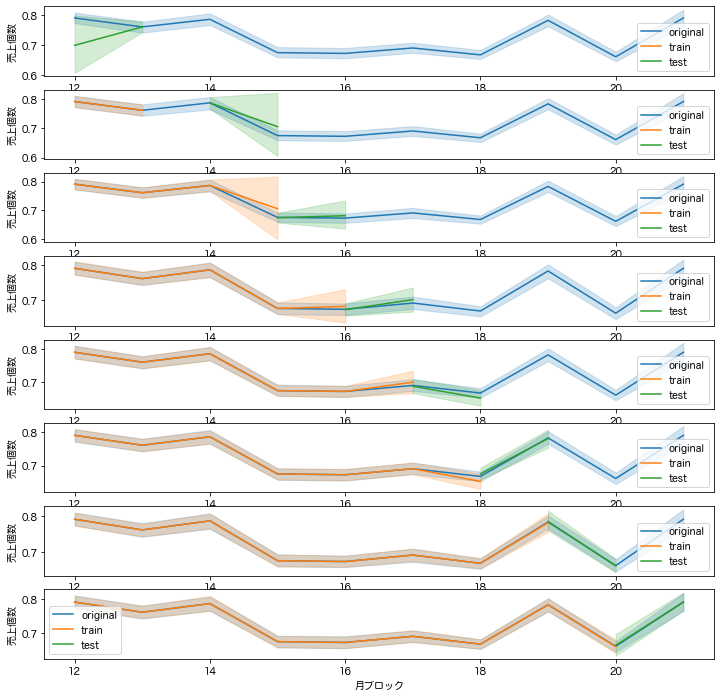

In [60]:
# df = pd.merge(X_trainval, y_trainval, right_index=True, left_index=True)

# n_splits = 8

# # データの並び順をシャッフルする
# df = df.sample(frac=1.0, random_state=42)

# # 特定のカラムを時系列としてソートした分割
# folds = MovingWindowKFold(ts_column='月ブロック', n_splits=n_splits)

# fig, axes = plt.subplots(n_splits, 1, figsize=(12, 12))

# # 元々のデータを時系列ソートした iloc が添字として得られる
# for i, (train_index, test_index) in enumerate(folds.split(df)):
#     #print(f'index of train: {train_index}')
#     #print(f'index of test: {test_index}')
#     #print('----------')
#     sns.lineplot(data=df, x='月ブロック', y='売上個数', ax=axes[i], label='original')
#     sns.lineplot(data=df.iloc[train_index], x='月ブロック', y='売上個数', ax=axes[i], label='train')
#     sns.lineplot(data=df.iloc[test_index], x='月ブロック', y='売上個数', ax=axes[i], label='test')

# plt.legend()
# plt.show()

In [52]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [53]:
import lightgbm as lgbm

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             n_splits,
             params: dict=None, 
             verbose: int=50):
    
    df = pd.merge(X, y, right_index=True, left_index=True)
    # データの並び順をシャッフルする
    df = df.sample(frac=1.0, random_state=42)
    # 特定のカラムを時系列としてソートした分割
    folds = MovingWindowKFold(ts_column='月ブロック', n_splits=n_splits)
    
    
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(folds.split(df)): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        lgb_train = lgb.Dataset(x_train, y_train) #(DataFrame, Series)
        lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train) #(DataFrame, Series)
        
        # 学習
        evaluation_results  = {}  # to record evaluation results for plotting
        with timer(prefix='fit fold={} '.format(i + 1)):
            model = lgb.train(params, 
                      lgb_train,
                      valid_names=['train', 'valid'], 
                      valid_sets=[lgb_train, lgb_valid],
                     evals_result = evaluation_results,
                    verbose_eval=verbose)
            
        pred_i = model.predict(x_valid, num_iteration=model.best_iteration)

        oof_pred[idx_valid] = pred_i
        models.append(model)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [54]:
params = {
     "objective":"regression",
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': 0.1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain', # 特徴重要度計算のロジック(後述)
    "random_seed":0,
}
params.update(best_params)
params['num_leaves'] = int(best_params['num_leaves'])
params['min_child_samples'] = int(best_params['min_child_samples'])
params['bagging_freq'] = int(best_params['bagging_freq'])
print(params)

{'objective': 'regression', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'importance_type': 'gain', 'random_seed': 100, 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 2.745289846464897e-08, 'lambda_l2': 0.025500402184799372, 'num_leaves': 79, 'feature_fraction': 1.0, 'bagging_fraction': 0.6037732655175806, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 5}


In [55]:
y = y_trainval.copy()
y = np.log1p(y) # log + plus1 変換する

In [56]:
n_splits = 5
oof, models = fit_lgbm(X_trainval, y, n_splits, params=params)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52434
[LightGBM] [Info] Number of data points in the train set: 109971, number of used features: 545
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] 

## 学習の確認

In [57]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

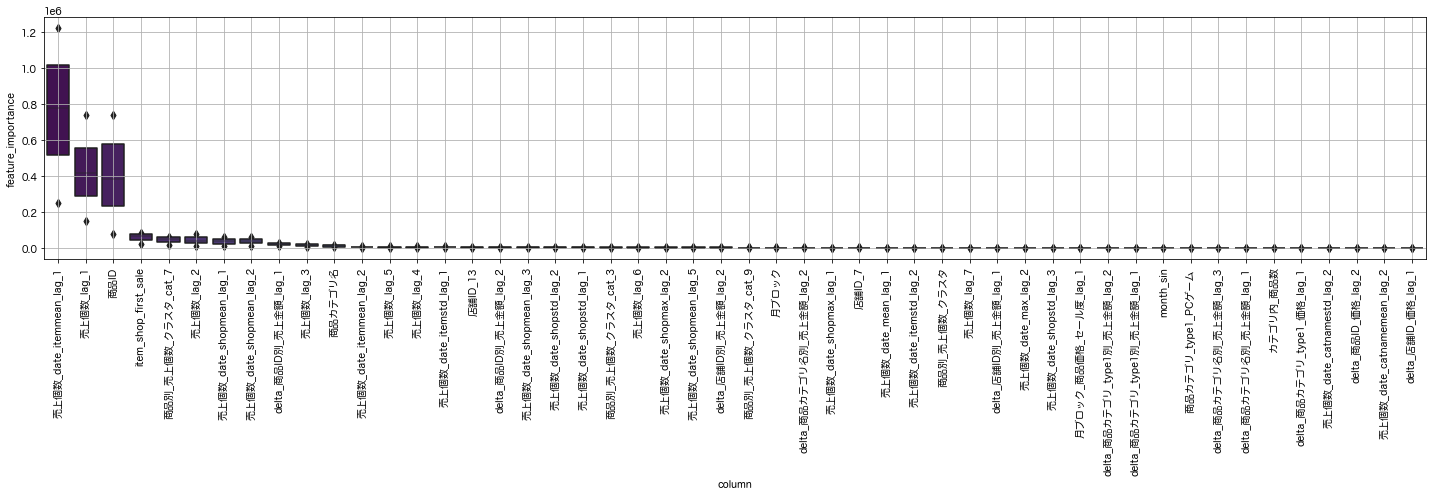

In [58]:
fig, ax = visualize_importance(models, X_trainval)

In [59]:
comparison_df = pd.DataFrame(y_trainval).rename(columns={'売上個数': 'true'})
comparison_df['pred'] = np.expm1(oof)

comparison_df['予測との誤差'] = np.sqrt((comparison_df['true'] - comparison_df['pred'])**2)
comparison_df['index'] = comparison_df.sort_values('予測との誤差', ascending=False).reset_index().index
comparison_df

true      pred    予測との誤差   index
331704    2.0  1.075680  0.924320       0
331705    0.0  0.730357  0.730357       1
331706    0.0  0.588064  0.588064       2
331707    0.0  0.533605  0.533605       3
331708    1.0  0.000000  1.000000       4
...       ...       ...       ...     ...
1076611   0.0  0.059323  0.059323  659821
1076612   0.0  0.177114  0.177114  659822
1076613   0.0  0.108463  0.108463  659823
1076614   0.0  0.000000  0.000000  659824
1076615   0.0  0.000000  0.000000  659825

[659826 rows x 4 columns]

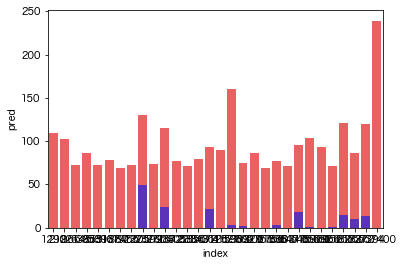

In [60]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[:30],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[:30],color='blue', alpha=0.7)
plt.show()

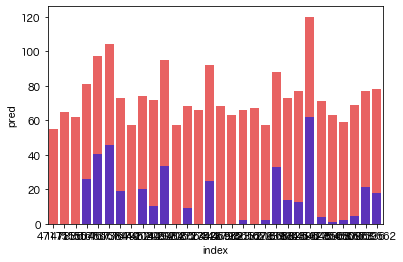

In [61]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[30:60],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[30:60],color='blue', alpha=0.7)
plt.show()

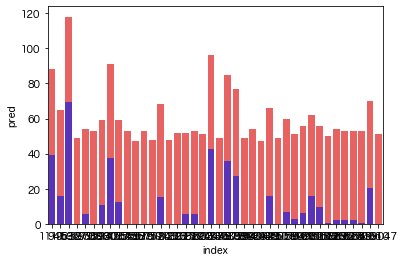

In [62]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[60:100],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[60:100],color='blue', alpha=0.7)
plt.show()

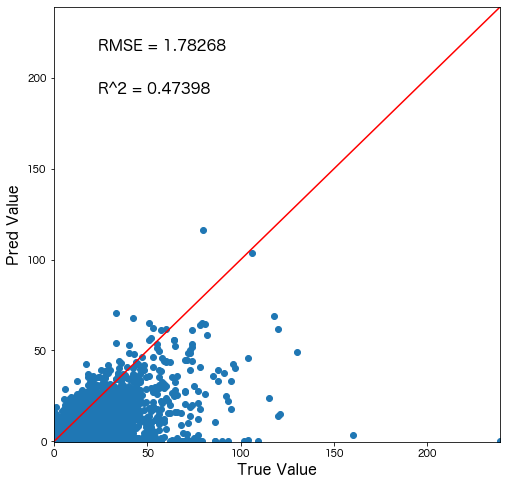

In [63]:
True_Pred_map(comparison_df[['true', 'pred']])

# 誤差の多いやつを再学習

In [64]:
# Failure_index = comparison_df[comparison_df['予測との誤差'] > 10].index
# len(Failure_index)

In [65]:
Failure_index = comparison_df.sort_values('予測との誤差', ascending=False).head(200000).sort_index().index
len(Failure_index)

200000

In [66]:
Failure_X_trainval = X_trainval.loc[Failure_index]
Failure_y = y[Failure_index]

In [67]:
params = {
     "objective":"regression",
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': 0.1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain', # 特徴重要度計算のロジック(後述)
    "random_seed":0,
}
params.update(best_params)
params['num_leaves'] = int(best_params['num_leaves'])
params['min_child_samples'] = int(best_params['min_child_samples'])
params['bagging_freq'] = int(best_params['bagging_freq'])
print(params)

n_splits = 5
Failure_oof, Failure_models = fit_lgbm(Failure_X_trainval, Failure_y, n_splits, params=params)

for model in Failure_models:
    models.append(model)

{'objective': 'regression', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'importance_type': 'gain', 'random_seed': 100, 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 2.745289846464897e-08, 'lambda_l2': 0.025500402184799372, 'num_leaves': 79, 'feature_fraction': 1.0, 'bagging_fraction': 0.6037732655175806, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 5}
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019289 seco

In [68]:
models

# 提出用ファイルの作成

In [69]:
models

In [71]:
pred = np.array([model.predict(X_test_month11.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
y_pred = pd.DataFrame({ '売上個数': pred })

In [72]:
y_pred

売上個数
0     0.774665
1     0.533948
2     0.892543
3     1.608001
4     4.004814
...        ...
3055  0.844929
3056  0.437225
3057  0.455269
3058  0.447218
3059  0.470590

[3060 rows x 1 columns]

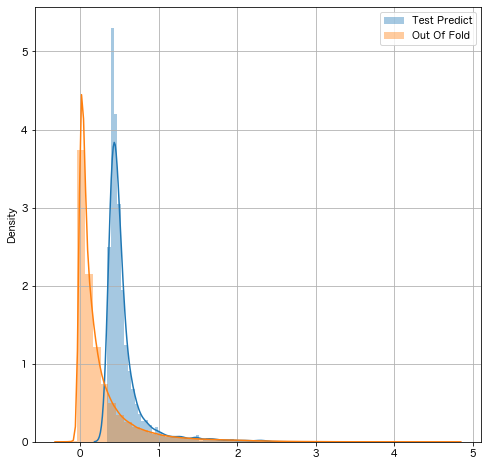

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(y_pred), label='Test Predict')
sns.distplot(oof, label='Out Of Fold')
ax.legend()
ax.grid()

In [74]:
# sample_submissionの中身を確認
sub.head()

0    1
0  0  100
1  1  100
2  2  100
3  3  100
4  4  100

In [75]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = y_pred

sub.head()

0         1
0  0  0.774665
1  1  0.533948
2  2  0.892543
3  3  1.608001
4  4  4.004814

In [76]:
# # ダミーの11月の売り上げファイルの生成
# sub.to_pickle('./inputs/dummy_sales_month11.pickle')

In [69]:
# # 予測ファイルの生成
# sub.to_csv('./outputs/submission17_LightGBM_TimeSeriesSplit_model_addfail.csv', index=False, header=False)